## 1.《誰在討論 MBTI？：以 Dcard 貼文進行主題分類與風格探索》 

## 目標
- 分析不同 MBTI 類型使用者在社群上的語言特徵與主題偏好?
- 能否透過文本自動預測其 MBTI 類型?
- 使用Transformer 模型與 NLP 技術，強化主題建模與情緒分析能力?


# 影片連結
- [社群媒體分析＿第02組＿期末報告](https://youtu.be/5fEJetltTuA)

## 大綱

### 1. 資料讀取與前處理
- 1.1 合併 MBTI 標記與文本
- 1.2 文字清洗（刪除特殊字元與無意義符號）
- 1.3 中文斷詞（可以用CKIP 或 BERT tokenizer）

### 2. 探索性分析（EDA）
- 2.1 每個 MBTI 類型的詞頻 / 字數分布
- 2.2 類型與詞彙、語氣的視覺化對比
- 2.3 文章情緒分析(利用Bert):情緒比例、性別/學校之情緒差異、留言數與情緒之關聯、時間軸之情緒變化?

### 3. 文字向量化（Text Embedding）
- 3.1 使用 Huggingface `bert-base-chinese` 或 `text2vec-base-chinese`
- 3.2 使用 word2vec
- 3.3 比較

### 4. 主題建模
- 4.1 BERTopic 模型建構與主題提取
- 4.2 主題視覺化
- 4.3 本地ollama+gemma3，利用top10 words定義主
### 5. 文本分類任務
- 5.1 任務:(predict 男女 or 主題)
- 5.2 評估指標：Accuracy、F1-score、Confusion Matrix


## 套件引用

In [59]:
#Python 準函式庫
import math
import os
import re
from collections import Counter
from itertools import combinations
from IPython.display import display, Markdown

#第三方函式庫
import jieba.analyse
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from ckip_transformers.nlp import CkipWordSegmenter
from gensim.models import Word2Vec, KeyedVectors, Phrases
from gensim.models.phrases import Phraser
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score
)
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud


# 設定中文字型
my_font = "./fonts/SourceHanSansTW-Regular.otf"
# 確保字型檔案存在，若不存在則使用預設
if os.path.exists(my_font):
    plt.rcParams["font.family"] = FontProperties(fname=my_font).get_name()
else:
    print(f"警告：找不到字型檔案 {my_font}，將使用 Matplotlib 預設字型。")

# 設定 PyTorch 使用 MPS (Mac GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 檢查GPU種類
torch_info = {
    "torch_version": torch.__version__,
    "cuda_available": torch.cuda.is_available(),
    "mps_available": torch.backends.mps.is_available(),
    "device_in_use": device
}

print(torch_info) 

{'torch_version': '2.4.1', 'cuda_available': False, 'mps_available': True, 'device_in_use': device(type='mps')}


### 一. 資料讀取與前處理

In [60]:
# 讀取資料
df = pd.read_csv('./rawData/MBTI_data.csv')

# 檢視資料基本結構
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   system_id     974 non-null    int64 
 1   dataSource    974 non-null    object
 2   artUrl        974 non-null    object
 3   artDate       974 non-null    object
 4   artTitle      974 non-null    object
 5   artContent    961 non-null    object
 6   boardID       974 non-null    object
 7   commentCount  974 non-null    int64 
 8   department    377 non-null    object
 9   gender        974 non-null    object
 10  school        593 non-null    object
dtypes: int64(2), object(9)
memory usage: 83.8+ KB
None
   system_id dataSource                                      artUrl  \
0          1      Dcard     https://www.dcard.tw/f/talk/p/257640963   
1          2      Dcard  https://www.dcard.tw/f/rainbow/p/257627205   
2          3      Dcard     https://www.dcard.tw/f/mood/p/257619302   
3        

In [61]:
# 資料合併與清理
# 處理空值
df['artContent'] = df['artContent'].fillna("")
# 合併標題與內文
df['content'] = df['artTitle'] + ":" + df['artContent']

# 給BERT用的變數(標點、表情符號和對bert來說有意義，所以新增一個欄位給bert用)
def clean_text_for_bert(text):
    if pd.isnull(text):
        return ""
    # 僅移除網址
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
    # 移除多餘空白，保留換行符號
    text = re.sub(r'[ \\t]+', ' ', text).strip() # 將多個空格或tab換成單一空格
    text = re.sub(r'\\n+', '\\n', text).strip() # 保留換行符號，但移除多餘的
    return text

df['content_for_bert'] = df['content'].apply(clean_text_for_bert)


# 簡單看幾筆
df[['system_id', 'content','content_for_bert']].head()

,system_id,content,content_for_bert
0,1,為什麼I人可以用I來當作不社交的藉口:如題，MBTI現在很紅，但我很不解有些I人常常碰到需要...,為什麼I人可以用I來當作不社交的藉口:如題，MBTI現在很紅，但我很不解有些I人常常碰到需要...
1,2,這麼剛好！:我和她的相遇，在盛夏。\n\n而偏偏，這個夏，颱風特別多，所以緣分恰似撞在了颱風...,這麼剛好！:我和她的相遇，在盛夏。\n\n而偏偏，這個夏，颱風特別多，所以緣分恰似撞在了颱風...
2,3,不回應就是不喜歡:雖然知道不管是星座還是MBTI都是參考用，\n但不管過了多久，還是會去翻看...,不回應就是不喜歡:雖然知道不管是星座還是MBTI都是參考用，\n但不管過了多久，還是會去翻看...
3,4,不知道姐姐對我有沒有好感:12/23在迪卡上認識了一個姐姐\n到今天已經連續聊一個禮拜\n因...,不知道姐姐對我有沒有好感:12/23在迪卡上認識了一個姐姐\n到今天已經連續聊一個禮拜\n因...
4,5,不去要ig就很膽小？？？:今天剛好悠閒來測mbti然後，我測試出來的是ENFP，我就把這個測...,不去要ig就很膽小？？？:今天剛好悠閒來測mb i然後，我測試出來的是ENFP，我就把這個測...


文本初步觀察有許多表情符號，做詞頻分析、n-gram、斷詞時先移除。

In [62]:
# 建立清理函數（針對詞頻、共現、LDA等任務使用）
def clean_text(text):
    if pd.isnull(text):
        return ""
    # 移除 emoji
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # 表情符號
                           u"\U0001F300-\U0001F5FF"  # 符號 & 圖示
                           u"\U0001F680-\U0001F6FF"  # 交通工具 & 地圖
                           u"\U0001F1E0-\U0001F1FF"  # 國旗
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # 移除網址
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # 移除非中文字、英文字母、數字（只保留簡單標點符號）
    text = re.sub(r"[^\u4e00-\u9fa5a-zA-Z0-9\s]", '', text)

    # 移除多餘空白
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 新增欄位 content_clean
df['content_clean'] = df['content'].apply(clean_text)

# 檢查前幾筆
df[['content', 'content_clean']].head(3)


,content,content_clean
0,為什麼I人可以用I來當作不社交的藉口:如題，MBTI現在很紅，但我很不解有些I人常常碰到需要...,為什麼I人可以用I來當作不社交的藉口如題MBTI現在很紅但我很不解有些I人常常碰到需要溝通的...
1,這麼剛好！:我和她的相遇，在盛夏。\n\n而偏偏，這個夏，颱風特別多，所以緣分恰似撞在了颱風...,這麼剛好我和她的相遇在盛夏 而偏偏這個夏颱風特別多所以緣分恰似撞在了颱風眼上 悄無聲息襯著神...
2,不回應就是不喜歡:雖然知道不管是星座還是MBTI都是參考用，\n但不管過了多久，還是會去翻看...,不回應就是不喜歡雖然知道不管是星座還是MBTI都是參考用 但不管過了多久還是會去翻看有關於你...


## CKIP斷詞

In [63]:
# 建立 ckip 斷詞器（GPU設0，CPU用 device=-1）
ws_driver = CkipWordSegmenter(device=device)
# 進行斷詞
df['tokens'] = ws_driver(df['content_clean'].tolist())
# 檢查
df[['content_clean', 'tokens']].head(5)

# 加強清理 (用更嚴格的方式去除符號、數字、雜訊)
with open("./dict/stopwords.txt", 'r', encoding='utf-8') as f:
    stop_words_zh = set([line.strip() for line in f])

stop_words_total = stop_words_zh.union(set(stopwords.words("english")))

def clean_tokens(tokens):
    return [
        w for w in tokens 
        if w not in stop_words_total 
        and len(w.strip()) > 1  
        and not re.match(r'^[\W_]+$', w)  
    ]

df['tokens_clean_strict'] = df['tokens'].apply(clean_tokens)

df.head()


Inference: 100%|██████████| 7/7 [01:25<00:00, 12.27s/it]


,system_id,dataSource,artUrl,artDate,artTitle,artContent,boardID,commentCount,department,gender,school,content,content_for_bert,content_clean,tokens,tokens_clean_strict
0,1,Dcard,https://www.dcard.tw/f/talk/p/257640963,2024-12-31 09:24:03,為什麼I人可以用I來當作不社交的藉口,如題，MBTI現在很紅，但我很不解有些I人常常碰到需要溝通的事情就說自己是I人，然後就把東西...,talk,104,NaN,M,國立臺灣大學,為什麼I人可以用I來當作不社交的藉口:如題，MBTI現在很紅，但我很不解有些I人常常碰到需要...,為什麼I人可以用I來當作不社交的藉口:如題，MBTI現在很紅，但我很不解有些I人常常碰到需要...,為什麼I人可以用I來當作不社交的藉口如題MBTI現在很紅但我很不解有些I人常常碰到需要溝通的...,"[為什麼, I, 人, 可以, 用, I, 來, 當作, 不, 社交, 的, 藉口, 如, ...","[當作, 社交, 藉口, MBTI, 不解, 碰到, 溝通, 事情, 東西, 丟給, 心態,..."
1,2,Dcard,https://www.dcard.tw/f/rainbow/p/257627205,2024-12-29 16:00:44,這麼剛好！,我和她的相遇，在盛夏。\n\n而偏偏，這個夏，颱風特別多，所以緣分恰似撞在了颱風眼上， 悄無...,rainbow,1,NaN,F,NaN,這麼剛好！:我和她的相遇，在盛夏。\n\n而偏偏，這個夏，颱風特別多，所以緣分恰似撞在了颱風...,這麼剛好！:我和她的相遇，在盛夏。\n\n而偏偏，這個夏，颱風特別多，所以緣分恰似撞在了颱風...,這麼剛好我和她的相遇在盛夏 而偏偏這個夏颱風特別多所以緣分恰似撞在了颱風眼上 悄無聲息襯著神...,"[這麼, 剛好, 我, 和, 她, 的, 相遇, 在, 盛夏, , 而, 偏偏, 這, 個...","[相遇, 盛夏, 颱風, 特別, 緣分, 颱風眼, 聲息, 神秘, 往後, 熱烈, 記得, ..."
2,3,Dcard,https://www.dcard.tw/f/mood/p/257619302,2024-12-28 15:16:42,不回應就是不喜歡,雖然知道不管是星座還是MBTI都是參考用，\n但不管過了多久，還是會去翻看有關於你的一切，好...,mood,3,NaN,F,NaN,不回應就是不喜歡:雖然知道不管是星座還是MBTI都是參考用，\n但不管過了多久，還是會去翻看...,不回應就是不喜歡:雖然知道不管是星座還是MBTI都是參考用，\n但不管過了多久，還是會去翻看...,不回應就是不喜歡雖然知道不管是星座還是MBTI都是參考用 但不管過了多久還是會去翻看有關於你...,"[不, 回應, 就是, 不, 喜歡, 雖然, 知道, 不管, 是, 星座, 還是, MBTI...","[回應, 喜歡, 星座, MBTI, 參考用, 多久, 翻看, 有關於, 想法, 在意, 裝..."
3,4,Dcard,https://www.dcard.tw/f/rainbow/p/257635779,2024-12-30 15:47:48,不知道姐姐對我有沒有好感,12/23在迪卡上認識了一個姐姐\n到今天已經連續聊一個禮拜\n因為我想說慢慢來所以聊的沒有...,rainbow,0,NaN,F,NaN,不知道姐姐對我有沒有好感:12/23在迪卡上認識了一個姐姐\n到今天已經連續聊一個禮拜\n因...,不知道姐姐對我有沒有好感:12/23在迪卡上認識了一個姐姐\n到今天已經連續聊一個禮拜\n因...,不知道姐姐對我有沒有好感1223在迪卡上認識了一個姐姐 到今天已經連續聊一個禮拜 因為我想說...,"[不, 知道, 姐姐, 對, 我, 有, 沒, 有, 好感, 1223, 在, 迪卡, 上,...","[姐姐, 好感, 1223, 迪卡, 姐姐, 連續, 禮拜, 慢慢, 主動, 擔心, 禮貌性..."
4,5,Dcard,https://www.dcard.tw/f/mood/p/257603606,2024-12-26 15:32:28,不去要ig就很膽小？？？,今天剛好悠閒來測mbti然後，我測試出來的是ENFP，我就把這個測試結果放在ig便利貼裡面，...,mood,9,NaN,F,NaN,不去要ig就很膽小？？？:今天剛好悠閒來測mbti然後，我測試出來的是ENFP，我就把這個測...,不去要ig就很膽小？？？:今天剛好悠閒來測mb i然後，我測試出來的是ENFP，我就把這個測...,不去要ig就很膽小今天剛好悠閒來測mbti然後我測試出來的是ENFP我就把這個測試結果放在i...,"[不, 去, 要, ig, 就, 很, 膽小, 今天, 剛好, 悠閒, 來, 測, mbti...","[ig, 膽小, 悠閒, 測試出來, ENFP, 測試, ig, 便利貼, 晚上, 朋友, ..."


## 二、探索性分析

In [64]:
# 定義ngram function
def generate_ngrams(tokens, n):
    return [' '.join(gram) for gram in ngrams(tokens, n)]

# 定義bigram和trigram的list
df['tokens_bigram_strict'] = df['tokens_clean_strict'].apply(lambda x: generate_ngrams(x, 2))
df['tokens_trigram_strict'] = df['tokens_clean_strict'].apply(lambda x: generate_ngrams(x, 3))

# 展開bigram和trigram的token
bigram_all = [gram for tokens in df['tokens_bigram_strict'] for gram in tokens]
trigram_all = [gram for tokens in df['tokens_trigram_strict'] for gram in tokens]

# 計數
bigram_counter = Counter(bigram_all)
trigram_counter = Counter(trigram_all)

# 只保留出現 >= 3 次
common_bigrams = [gram for gram, freq in bigram_counter.items() if freq >= 3]
common_trigrams = [gram for gram, freq in trigram_counter.items() if freq >= 3]

print(f"高頻 Bigram (>=3)：{common_bigrams[:10]}")
print(f"高頻 Trigram (>=3)：{common_trigrams[:10]}")


高頻 Bigram (>=3)：['見到 陌生人', '喜歡 社交', '喜歡 感覺', '感覺 MBTI', '生活 工作', '事情 喜歡', '內向 社交', '交友 軟體', '配對 成功', 'MBTI 星座']
高頻 Trigram (>=3)：['MBTI 星座 血型', '擅長 表達 情緒', '1215 聖誕 單身', '聖誕 單身 聯誼', '單身 聯誼 交友', '聯誼 交友 女生', '交友 女生 報名', '女生 報名 免費', '報名 免費 聖誕節', '免費 聖誕節 參加']


## 詞頻統計

In [65]:
# 計算詞頻
from collections import Counter

all_clean_tokens_strict = [word for tokens in df['tokens_clean_strict'] for word in tokens]
strict_word_freq = Counter(all_clean_tokens_strict)
strict_word_freq_df = pd.DataFrame(strict_word_freq.items(), columns=['word', 'freq']).sort_values(by='freq', ascending=False)
strict_word_freq_df.head(20)




,word,freq
28,喜歡,1277
159,真的,1051
157,朋友,995
136,時間,648
32,工作,637
202,希望,633
3,MBTI,591
800,女生,530
29,感覺,521
260,分享,462


## 文字雲

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

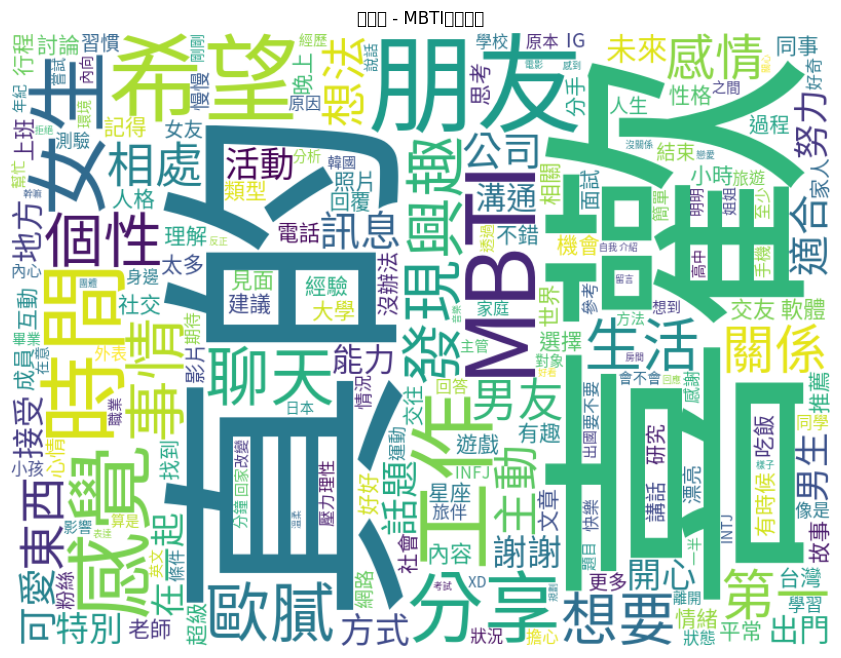

In [66]:
# 先把所有 tokens 串接成一個長字串
all_text = " ".join(all_clean_tokens_strict)

# 產生文字雲
wordcloud = WordCloud(font_path=my_font, background_color="white", width=800, height=600).generate(all_text)


# 繪製文字雲
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("文字雲 - MBTI討論文本")
plt.show()


## 共現詞分析

共線頻率:
對每篇文章中出現的詞，組合所有兩兩詞組，計算這些詞對在所有文章中的出現次數(不重複，文章內同一詞對只計一次),最後輸出共現頻率最高的 20 對詞。

In [67]:
# 使用 tokens_clean_strict
token_lists = df['tokens_clean_strict'].dropna().tolist()

# 共現統計
co_occurrence = Counter()
for tokens in token_lists:
    unique_tokens = set(tokens)
    for pair in combinations(unique_tokens, 2):
        co_occurrence[tuple(sorted(pair))] += 1

co_occurrence.most_common(20)


[(('喜歡', '真的'), 226),
 (('喜歡', '朋友'), 221),
 (('朋友', '真的'), 191),
 (('喜歡', '希望'), 187),
 (('MBTI', '真的'), 165),
 (('MBTI', '朋友'), 165),
 (('喜歡', '興趣'), 165),
 (('喜歡', '時間'), 164),
 (('希望', '朋友'), 162),
 (('時間', '朋友'), 162),
 (('分享', '喜歡'), 160),
 (('感覺', '真的'), 156),
 (('希望', '真的'), 155),
 (('喜歡', '感覺'), 153),
 (('MBTI', '喜歡'), 153),
 (('個性', '喜歡'), 153),
 (('分享', '真的'), 147),
 (('喜歡', '工作'), 144),
 (('希望', '興趣'), 141),
 (('喜歡', '聊天'), 140)]

PMI(Pointwise Mutual Information)
在上面共現頻率結果進一步計算 PMI，PMI考慮每對詞的共同出現機率，相較於它們各自單獨出現的機率。
讓我們排除掉純粹因為高頻而共現的詞，而發現更具有內在關聯，例如兩個罕見詞，但總是一起出現，PMI 會很高。

In [68]:
word_count = Counter()
pair_count = Counter()
total_sentences = len(token_lists)

for tokens in token_lists:
    unique_tokens = set(tokens)
    for token in unique_tokens:
        word_count[token] += 1
    for pair in combinations(unique_tokens, 2):
        pair_count[tuple(sorted(pair))] += 1

pmi_scores = {}
for (w1, w2), pair_freq in pair_count.items():
    p_w1 = word_count[w1] / total_sentences
    p_w2 = word_count[w2] / total_sentences
    p_w1w2 = pair_freq / total_sentences
    pmi = math.log2(p_w1w2 / (p_w1 * p_w2))
    pmi_scores[(w1, w2)] = pmi

sorted(pmi_scores.items(), key=lambda x: x[1], reverse=True)[:20]


[(('發酵', '電量'), 9.927777962082342),
 (('停電', '電量'), 9.927777962082342),
 ((' ok', '電量'), 9.927777962082342),
 (('亂撞', '電量'), 9.927777962082342),
 (('不尋常', '電量'), 9.927777962082342),
 (('押後', '電量'), 9.927777962082342),
 (('小鹿', '電量'), 9.927777962082342),
 (('電量', '黏膩'), 9.927777962082342),
 (('酷熱', '電量'), 9.927777962082342),
 (('期末週', '電量'), 9.927777962082342),
 (('盛夏', '電量'), 9.927777962082342),
 (('電量', '颱風眼'), 9.927777962082342),
 (('悶熱', '電量'), 9.927777962082342),
 (('聲息', '電量'), 9.927777962082342),
 (('難耐', '電量'), 9.927777962082342),
 (('紅點', '電量'), 9.927777962082342),
 (('共振', '電量'), 9.927777962082342),
 (('酷暑', '電量'), 9.927777962082342),
 (('停電', '發酵'), 9.927777962082342),
 ((' ok', '發酵'), 9.927777962082342)]

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.


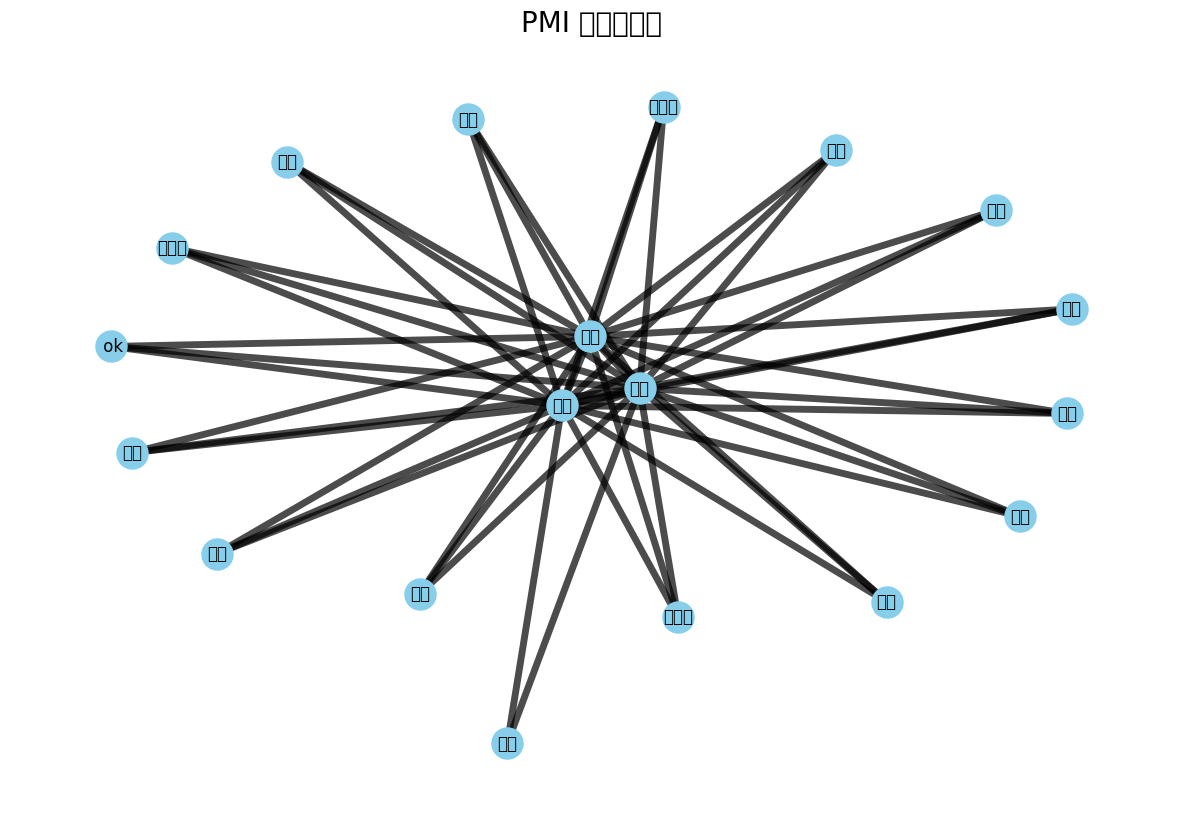

In [69]:
# 全域設定中文字型
my_font = FontProperties(fname="./fonts/SourceHanSansTW-Regular.otf")
rcParams['font.family'] = my_font.get_name()

# 畫 PMI 共現詞網絡
# 取 PMI 最高前 50 對
top_pmi_pairs = sorted(pmi_scores.items(), key=lambda x: x[1], reverse=True)[:50]
G = nx.Graph()
for (w1, w2), score in top_pmi_pairs:
    G.add_edge(w1, w2, weight=score)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]

nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edgelist=edges, width=[w*0.5 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=12)  # 移除 font_family
plt.title("PMI 共現詞網絡", fontsize=20)
plt.axis('off')
plt.show()




## 2.3情緒分析(BERT)

載入套件

In [70]:
# 載入模型
tokenizer_sent = AutoTokenizer.from_pretrained("uer/roberta-base-finetuned-jd-binary-chinese")
model_sent = AutoModelForSequenceClassification.from_pretrained("uer/roberta-base-finetuned-jd-binary-chinese")

# 預測 function
def predict_sentiment(text):
    inputs = tokenizer_sent(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model_sent(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    if scores.nelement() == 0:
        return np.array([0.5, 0.5]) 
    return scores[0].cpu().numpy()

## 2.3.1整體文章情緒分布

BERT本身有 tokenizer，可以處理斷詞、標點符號、數字、特殊符號、padding、masking等等，起初規劃只餵一開始定義“artTitle”+"artContent"的變數。
bert-base-chinese, text2vec-base-chinese預設 最大token數是512，目前有些文章token超過1200個token。
但BERT的輸入變數是原始文本，給做過token clean的資料反而會失去語境，目前以下面三個方法處理文本並檢查資料的情緒分布：
<ol>
<li>Truncate 強制截斷:目前以"content"欄位+超過512 tokens就截斷的方法嘗試</li>
<li>Sliding Window 滑動視窗</li>
<li>Summary(TextRank 摘要)</li>
</ol>

In [71]:
#1.截斷法
def predict_sentiment_truncate(text):
    inputs = tokenizer_sent(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model_sent(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    return scores[0].cpu().numpy()

df['sentiment_score_truncate'] = df['content_for_bert'].apply(predict_sentiment_truncate)
df['sentiment_label_truncate'] = df['sentiment_score_truncate'].apply(lambda x: 'Positive' if np.argmax(x) == 1 else 'Negative')

In [72]:
#2.移動視窗法
def sliding_window_chunks(text, tokenizer, max_length=512, stride=256):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    chunks = []
    start = 0
    while start < len(tokens):
        end = start + max_length
        chunk = tokens[start:end]
        chunks.append(chunk)
        if end >= len(tokens):
            break
        start += stride
    return chunks

def predict_sentiment_sliding(text):
    chunks = sliding_window_chunks(text, tokenizer_sent)
    scores = []
    for chunk in chunks:
        inputs = tokenizer_sent.decode(chunk)
        tokenized = tokenizer_sent(inputs, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model_sent(**tokenized)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        scores.append(probs[0].cpu().numpy())
    avg_score = np.mean(scores, axis=0)
    return avg_score

df['sentiment_score_sliding'] = df['content_for_bert'].apply(predict_sentiment_sliding)
df['sentiment_label_sliding'] = df['sentiment_score_sliding'].apply(lambda x: 'Positive' if np.argmax(x) == 1 else 'Negative')


In [73]:
# TextRank摘要function（取N個關鍵句）
def summarize_text_textrank(text, topK=5):
    try:
        # jieba.analyse.textrank 提取的是關鍵詞，不是句子。
        if not text or not text.strip():
            return "" 
        keywords = jieba.analyse.textrank(text, topK=topK, withWeight=False, allowPOS=('ns', 'n', 'vn', 'v'))
        return " ".join(keywords)
    except Exception as e:
        print(f"Summarization failed for: {text[:50]}...  Error: {e}")
        return text 

# 建立摘要欄位（用content欄位）
df['content_summary'] = df['content'].apply(lambda x: summarize_text_textrank(x, topK=5))

# 先Summary再餵BERT 做情緒分析
df['sentiment_score_summary'] = df['content_summary'].apply(predict_sentiment)
df['sentiment_label_summary'] = df['sentiment_score_summary'].apply(lambda x: 'Positive' if np.argmax(x) == 1 else 'Negative')

print("content_summary和sentiment_score_summary的幾筆樣本")
print(df[['content_summary', 'sentiment_score_summary']].head())



content_summary和sentiment_score_summary的幾筆樣本
   content_summary    sentiment_score_summary
0  事情 溝通 喜歡 陌生人 社交  [0.069008484, 0.93099153]
1   手機 滑著 覆去 時候 找到     [0.4270026, 0.5729974]
2   知道 喜歡 回應 星座 想法   [0.026288517, 0.9737115]
3   知道 沒有 話題 姐姐 禮貌   [0.26694652, 0.73305345]
4   看到 測試 朋友 外向 造成    [0.32565835, 0.6743417]


findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

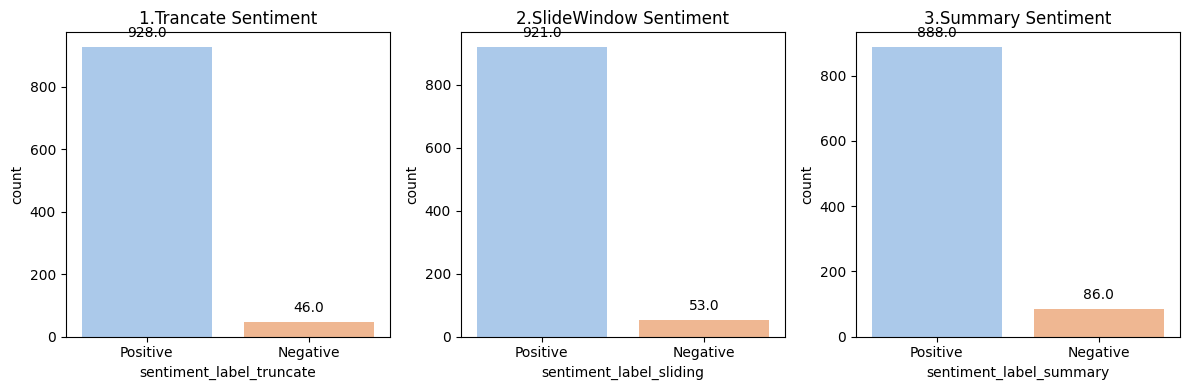

In [74]:
#視覺化
plt.figure(figsize=(12, 4))

def add_count_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.subplot(1, 3, 1)
ax1 = sns.countplot(data=df, x='sentiment_label_truncate', palette='pastel')
plt.title('1.Trancate Sentiment')
add_count_labels(ax1)

plt.subplot(1, 3, 2)
ax2 = sns.countplot(data=df, x='sentiment_label_sliding', palette='pastel')
plt.title('2.SlideWindow Sentiment')
add_count_labels(ax2) 

plt.subplot(1, 3, 3)
ax3 = sns.countplot(data=df, x='sentiment_label_summary', palette='pastel')
plt.title('3.Summary Sentiment')
add_count_labels(ax3) 

plt.tight_layout()
plt.show()


## 2.3.2 文章情緒與學校、性別之關聯

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

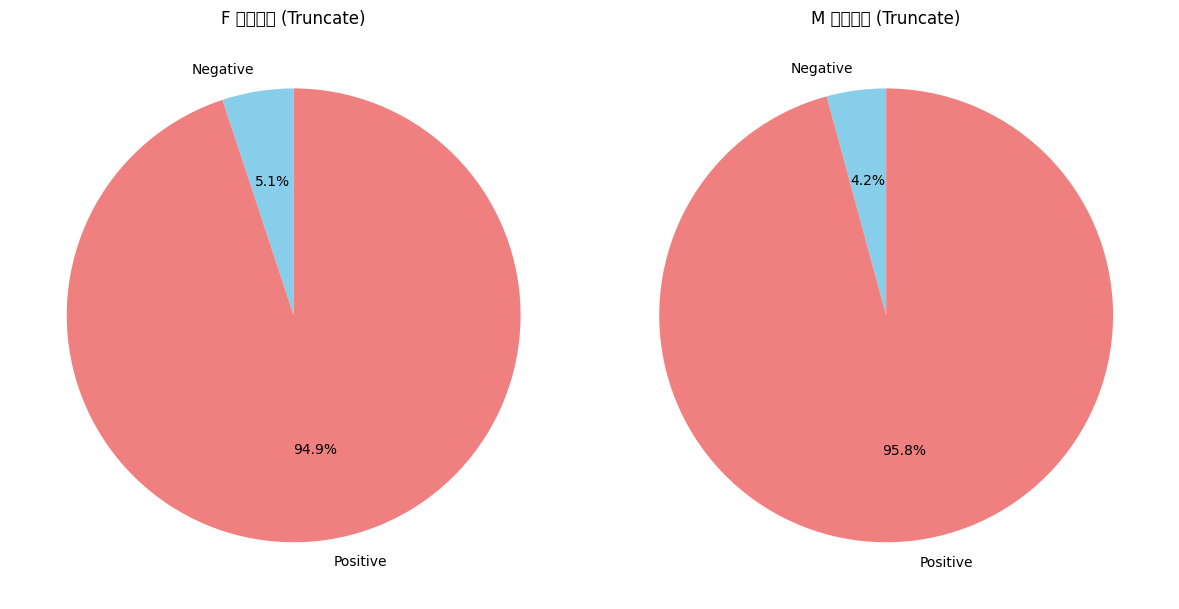

In [75]:
# 扣掉gender是'D' 的資料
filtered_gender_sentiment_counts = df[df['gender'] != 'D'].groupby(['gender', 'sentiment_label_truncate']).size().unstack(fill_value=0)

# 繪圖function
def plot_pie_chart(data, title):
    fig, axes = plt.subplots(1, len(data.index), figsize=(12, 6))  #每個性別一個子圖

    for i, (gender, sentiment_counts) in enumerate(data.iterrows()):
        labels = sentiment_counts.index
        sizes = sentiment_counts.values

        #算比例
        total = sum(sizes)
        percentages = [size / total * 100 for size in sizes]

        #圓餅圖
        axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
        axes[i].set_title(f'{gender} ' + title)  # 設定子圖標題

    plt.tight_layout()
    plt.show()

# 性別與情緒的圓餅圖
plot_pie_chart(filtered_gender_sentiment_counts, '情緒分佈 (Truncate)')



## 2.3.3 文章情緒與留言數之關聯

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

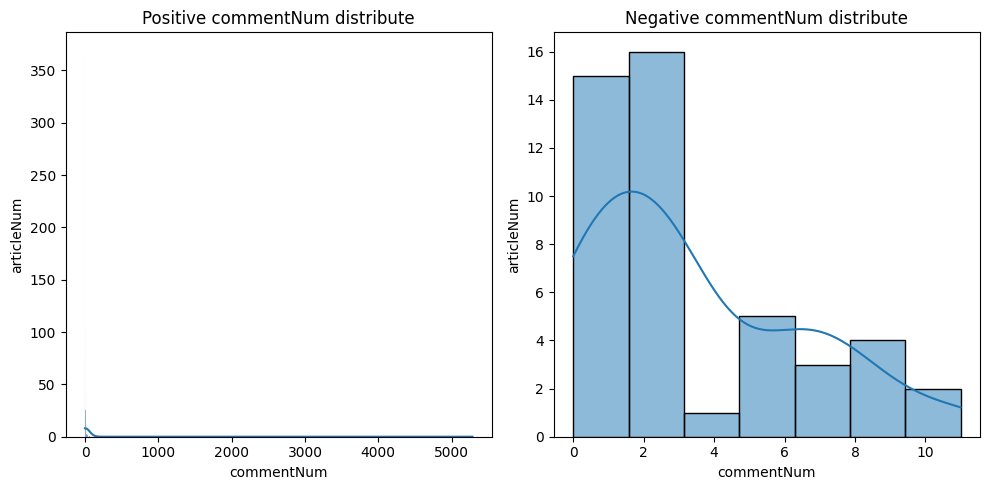

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

for sentiment in df['sentiment_label_truncate'].unique():
    plt.subplot(1, 2, 1 if sentiment == 'Positive' else 2) # 假設只有 '正面' 和 '負面'
    sns.histplot(df[df['sentiment_label_truncate'] == sentiment]['commentCount'], kde=True)
    plt.title(f'{sentiment} commentNum distribute')
    plt.xlabel('commentNum')
    plt.ylabel('articleNum')

plt.tight_layout()
plt.show()



## 2.3.4 發文時間與情緒之關聯

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

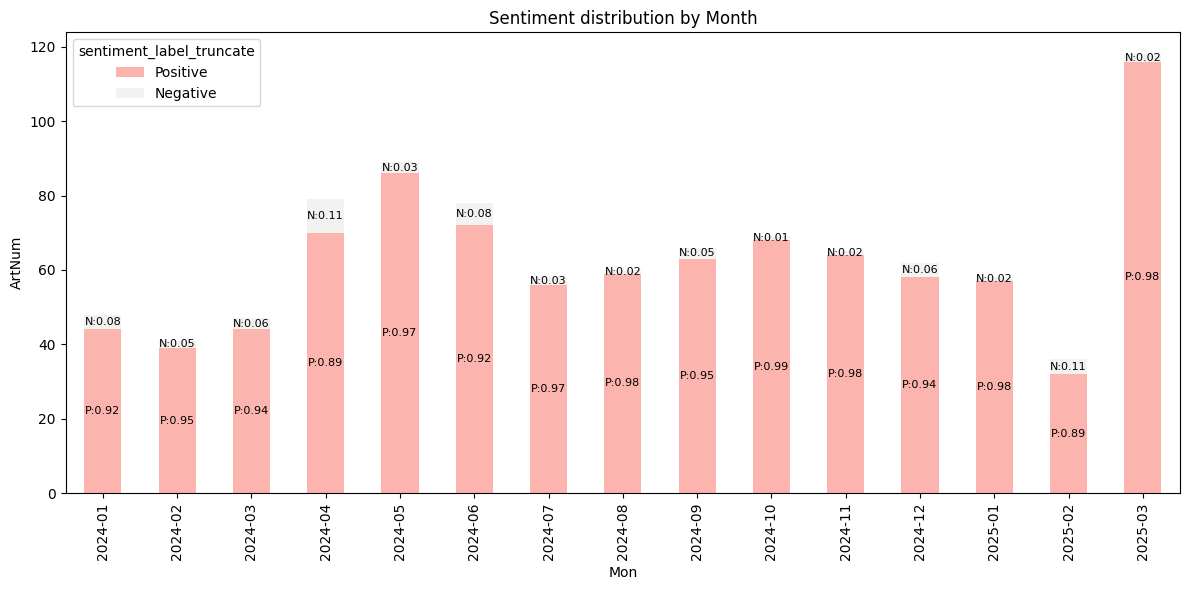

In [77]:
import matplotlib.pyplot as plt
import pandas as pd

# 將 artDate 轉為 datetime 格式
df['artDate'] = pd.to_datetime(df['artDate'], errors='coerce')

# 計算每月的情緒分布
sentiment_by_month = df.groupby([df['artDate'].dt.to_period('M'), 'sentiment_label_truncate']).size().unstack(fill_value=0).fillna(0)

# 計算總數和比例
sentiment_by_month['Total'] = sentiment_by_month.sum(axis=1)
sentiment_by_month['Positive_Ratio'] = sentiment_by_month['Positive'] / sentiment_by_month['Total']
sentiment_by_month['Negative_Ratio'] = sentiment_by_month['Negative'] / sentiment_by_month['Total']

# 繪圖
fig, ax = plt.subplots(figsize=(12, 6))
sentiment_by_month[['Positive', 'Negative']].plot(kind='bar', stacked=True, ax=ax, colormap='Pastel1')
plt.title('Sentiment distribution by Month')
plt.ylabel('ArtNum')
plt.xlabel('Mon')

# 比例文字
for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if i < len(ax.patches) / 2:  # 只在 '正面' 的長條上添加文字
        ratio = sentiment_by_month['Positive_Ratio'].iloc[i]
        ax.annotate(f'P:{ratio:.2f}', (x + width/2, y + height/2), ha='center', va='center', color='black', fontsize=8)
    else:  # 在 '負面' 的長條上添加文字
        ratio = sentiment_by_month['Negative_Ratio'].iloc[i - len(ax.patches) // 2]
        ax.annotate(f'N:{ratio:.2f}', (x + width/2, y + height/2), ha='center', va='center', color='black', fontsize=8)

plt.tight_layout()
plt.show()



## 三、文字向量化 (Bert)

## 3.1 BERT Embedding

### 3.1.1 BERT Embedding 獲取

In [78]:
# 使用 Huggingface 的中文 sentence-BERT
model = SentenceTransformer('shibing624/text2vec-base-chinese', device=device)

# 取 content_clean 欄位（斷詞可以不用，直接用乾淨句子即可，BERT自己會做tokenize）
df['content_clean_text'] = df['tokens_clean_strict'].apply(lambda x: ' '.join(x))

# 轉換為list
corpus = df['content_clean_text'].tolist()

# 建向量
corpus_embeddings = model.encode(corpus, batch_size=32, show_progress_bar=True, convert_to_tensor=True)

print(f"句子數: {len(corpus)}, 向量維度: {corpus_embeddings.shape}")

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

句子數: 974, 向量維度: torch.Size([974, 768])


### 3.1.2 BERT Embedding 視覺化（t-SNE / UMAP）

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

\n--- DataFrame Head with 'bert_embedding' column ---
                                  content_clean_text  \
0  當作 社交 藉口 MBTI 不解 碰到 溝通 事情 東西 丟給 心態 大學 社會 客戶 見到...   
1  相遇 盛夏 颱風 特別 緣分 颱風眼 聲息 神秘 往後 熱烈 記得 相遇 停電 十幾 小時 ...   
2         回應 喜歡 星座 MBTI 參考用 多久 翻看 有關於 想法 在意 裝作 忙碌 回應   
3  姐姐 好感 1223 迪卡 姐姐 連續 禮拜 慢慢 主動 擔心 禮貌性 回覆 聊天 話題 展...   
4  ig 膽小 悠閒 測試出來 ENFP 測試 ig 便利貼 晚上 朋友 留言 便利貼 真的 E...   

                                      bert_embedding  
0  [0.58128124, -0.28123027, 0.4304186, 0.3381570...  
1  [0.5745821, -0.015759524, 0.40353978, 0.227184...  
2  [0.5093131, -0.80934423, 0.32532933, -0.067983...  
3  [0.038932014, 0.056575507, 0.12833151, 0.18441...  
4  [0.6972787, -0.2349903, -0.025045296, 0.812995...  
Shape of first embedding: (768,)
Type of first embedding: <class 'numpy.ndarray'>


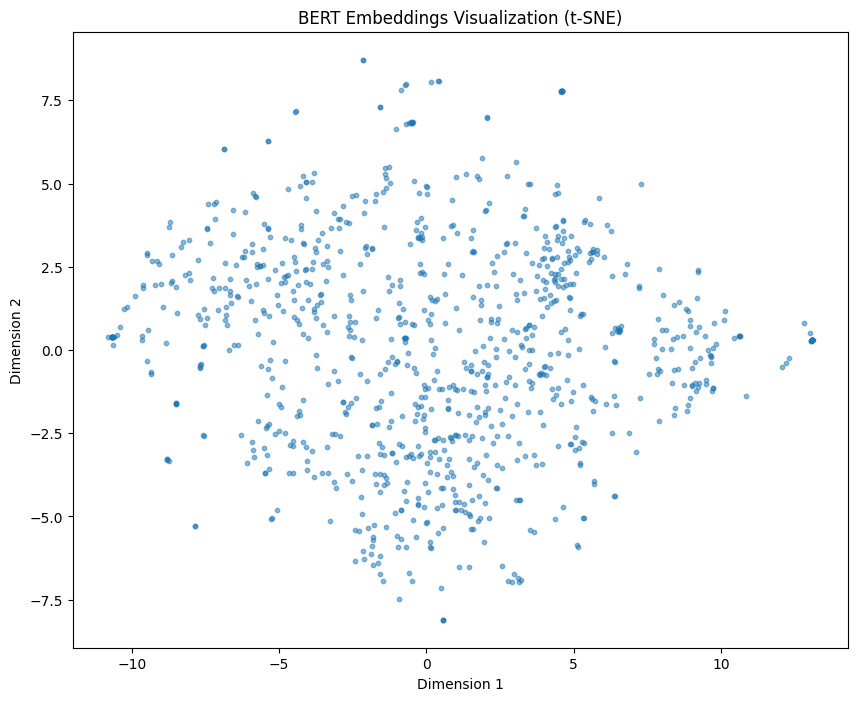

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE  # 或 from umap import UMAP
import seaborn as sns

# 1. 降維(用t-SNE)
tsne = TSNE(n_components=2, random_state=42, n_iter=300) # 可以調整參數
embeddings_2d = tsne.fit_transform(corpus_embeddings.cpu().numpy())  # 將 embeddings 移到 CPU
# 檢查 corpus_embeddings 的類型並轉換
if isinstance(corpus_embeddings, torch.Tensor):
    df['bert_embedding'] = list(corpus_embeddings.cpu().numpy())
else: # 如果 corpus_embeddings 已經是 numpy array
    df['bert_embedding'] = list(corpus_embeddings)

# 檢查 bert_embedding 欄位是不是新增成功
print("\\n--- DataFrame Head with 'bert_embedding' column ---")
print(df[['content_clean_text', 'bert_embedding']].head())
# 打印第一篇文章的 embedding 的形狀和類型，以確認
if not df.empty and 'bert_embedding' in df.columns and len(df['bert_embedding'].iloc[0]) > 0:
    print(f"Shape of first embedding: {df['bert_embedding'].iloc[0].shape}")
    print(f"Type of first embedding: {type(df['bert_embedding'].iloc[0])}")
else:
    print("Could not retrieve first embedding for shape/type check.")


# 2. 視覺化
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=10, alpha=0.5)
plt.title('BERT Embeddings Visualization (t-SNE)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


## 3.2 Word2Vec Embedding

### 3.2.1 Word2Vec 模型訓練

In [80]:
# 1.訓練資料
sentences = df['tokens_clean_strict'].tolist()  # 假設 df['tokens_clean_strict'] 已經是斷詞後的句子列表
# 2.訓練 Word2Vec 
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)  # 可以調整參數
# 3.存embedding
word_vectors = w2v_model.wv

### 3.2.2 Word2Vec Embedding 視覺化

findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Source Han Sans TW' not found.
findfont: Font family 'Sourc

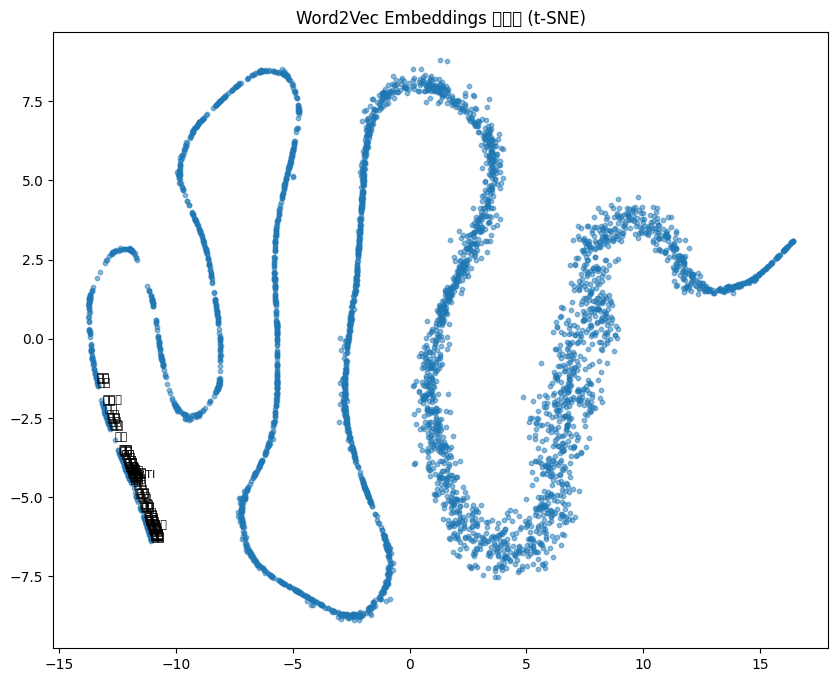

In [81]:
# 算word2Vec 模型中所有詞語的向量
all_words = list(word_vectors.key_to_index.keys())
all_vectors = [word_vectors[word] for word in all_words]
all_vectors = np.array(all_vectors)  # 轉換為 numpy 陣列

# 使用t-SNE 降維
tsne = TSNE(n_components=2, random_state=42, n_iter=300)
embeddings_2d_w2v = tsne.fit_transform(all_vectors)

# 繪製散佈圖
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d_w2v[:, 0], embeddings_2d_w2v[:, 1], s=10, alpha=0.5)

# 標註部分詞語
for i, word in enumerate(all_words[:100]):  # 只標註前100 個詞語以免太擁擠 可以自己改
    plt.annotate(word, xy=(embeddings_2d_w2v[i, 0], embeddings_2d_w2v[i, 1]), fontsize=8)

plt.title('Word2Vec Embeddings 視覺化 (t-SNE)')
plt.show()

## 3.3 Bert/Word2Vec比較

In [82]:
# 3.3 BERT 與 Word2Vec 比較
# 3.3.1 詞匯覆蓋率比較
def compare_vocab(word_vectors, model, df):
    w2v_vocab = set(word_vectors.key_to_index.keys())
    print(f"Word2Vec 詞彙量: {len(w2v_vocab)}")

compare_vocab(word_vectors, model, df)

# 3.3.2 詞語相似度比較
def compare_word_similarity(word1, word2, word_vectors, model):
    print(f"\n--- 詞語相似度比較: {word1} vs. {word2} ---")

    # Word2Vec
    try:
        w2v_similarity = word_vectors.similarity(word1, word2)
        print(f"Word2Vec 相似度: {w2v_similarity:.4f}")
    except KeyError:
        print(f"Word2Vec 中找不到詞語: {word1} 或 {word2}")

    # BERT
    bert_similarity = model.encode([word1, word2], convert_to_tensor=True)
    print(f"BERT 相似度: {util.cos_sim(bert_similarity[0], bert_similarity[1]).item():.4f}")

    # Word2Vec 找出最相似詞語
    try:
        print(f"\nWord2Vec 中最相似於 {word1} 的詞語:")
        for sim_word, sim_score in word_vectors.most_similar(word1, topn=10):
            print(f"{sim_word}: {sim_score:.4f}")
    except KeyError:
        print(f"Word2Vec 中找不到詞語: {word1}")

compare_word_similarity("開心", "快樂", word_vectors, model)
compare_word_similarity("內向", "外向", word_vectors, model)
compare_word_similarity("思考", "情感", word_vectors, model)

# 3.3.3 文章相似度比較 (BERT與word2Vec)
def compare_document_similarity(model, word_vectors, df, corpus_embeddings, top_n=5):
    """
    比較 BERT 和 Word2Vec 的文章相似度 (僅印出標題/ID)。

    Args:
        model: BERT 模型 (SentenceTransformer).
        word_vectors: Word2Vec 的詞向量.
        df: 包含文章資料的 DataFrame (需要有 'content' 和可選的 'artTitle' 或 'id' 欄位).
        corpus_embeddings: BERT 文章 embeddings.
        top_n: 要印出的最相似文章數量.
    """

    query_num = 0  # 任意一篇
    query_text = df['content'].iloc[query_num]

    print(f"\n--- 文章相似度比較 (Query 文章 {query_num}): ---\n")

    # 檢查'artTitle' 欄位存在，並處理空值
    if 'artTitle' in df:
        df['artTitle'] = df['artTitle'].fillna('No Title')
        print(f"Query Title: {df['artTitle'].iloc[query_num]}\n")
    else:
        print("artTitle column not found.\n")

    print(f"Query Content:\n{query_text}\n")

    # 1. BERT相似度
    print("\n--- BERT 相似文章 ---")
    query_embedding_bert = corpus_embeddings[query_num]
    cos_scores_bert = util.cos_sim(query_embedding_bert, corpus_embeddings)[0]
    top_results_bert = torch.topk(cos_scores_bert, k=top_n + 1)  # +1 to exclude the query itself

    for i, (score, idx) in enumerate(zip(top_results_bert[0][1:], top_results_bert[1][1:])): 
        print(f"\nRank {i + 1}, BERT Score: {score:.4f}")
        if 'artTitle' in df:
            print(f"Title: {df['artTitle'].iloc[idx.item()]}")
        if 'id' in df:
            print(f"ID: {df['id'].iloc[idx.item()]}")

    # 2.Word2Vec 相似度
    print("\n--- Word2Vec 相似文章 (平均詞向量) ---")
    tokens_column_name = 'tokens_clean_strict'
    if tokens_column_name not in df.columns:
        print(f"Error: Tokenized column '{tokens_column_name}' not found in DataFrame.")
        return

    query_words = df[tokens_column_name].iloc[query_num]
    if len(query_words) == 0:
        print("Query 文章沒有詞語，無法計算 Word2Vec 相似度.")
    else:
        try:
            query_embedding_w2v = np.mean(
                [word_vectors[word] for word in query_words if word in word_vectors], axis=0
            )
            if np.isnan(query_embedding_w2v).any():
                print("Query 文章的詞語不在 Word2Vec 詞彙表中，無法計算相似度.")
            else:
                similarities_w2v = {}
                for i, words in enumerate(df[tokens_column_name]):
                    if len(words) > 0:
                        article_embedding_w2v = np.mean(
                            [word_vectors[word] for word in words if word in word_vectors], axis=0
                        )
                        if not np.isnan(article_embedding_w2v).any():
                            similarities_w2v[i] = np.dot(query_embedding_w2v, article_embedding_w2v) / (
                                np.linalg.norm(query_embedding_w2v) * np.linalg.norm(article_embedding_w2v) + 1e-8
                            )  # 防止除以0

                # Word2Vec 相似度分數
                max_similarity = max(similarities_w2v.values()) if similarities_w2v else 1.0  # 避免空字典
                normalized_similarities_w2v = {k: v / max_similarity for k, v in similarities_w2v.items()}

                top_articles_w2v = sorted(normalized_similarities_w2v.items(), key=lambda item: item[1], reverse=True)[
                    :top_n
                ]

                for i, (idx, score) in enumerate(top_articles_w2v):
                    print(f"\nRank {i + 1}, Word2Vec Score: {score:.4f}")
                    if 'artTitle' in df:
                        print(f"Title: {df['artTitle'].iloc[idx]}")
                    if 'id' in df:
                        print(f"ID: {df['id'].iloc[idx]}")

        except KeyError as e:
            print(f"Word2Vec 詞彙表中找不到詞語: {e}")

#  model, word_vectors, df, corpus_embeddings 已經定義好
compare_document_similarity(model, word_vectors, df, corpus_embeddings)

Word2Vec 詞彙量: 4195

--- 詞語相似度比較: 開心 vs. 快樂 ---
Word2Vec 相似度: 0.9995
BERT 相似度: 0.7628

Word2Vec 中最相似於 開心 的詞語:
要不要: 0.9997
東西: 0.9997
擔心: 0.9997
回家: 0.9997
離開: 0.9997
故事: 0.9997
有時候: 0.9996
剛剛: 0.9996
對話: 0.9996
感覺: 0.9996

--- 詞語相似度比較: 內向 vs. 外向 ---
Word2Vec 相似度: 0.9996
BERT 相似度: 0.7526

Word2Vec 中最相似於 內向 的詞語:
個性: 0.9996
外向: 0.9996
敏感: 0.9995
回答: 0.9994
尊重: 0.9994
社會: 0.9994
理解: 0.9994
 MBTI: 0.9994
社交: 0.9994
溫柔: 0.9994

--- 詞語相似度比較: 思考 vs. 情感 ---
Word2Vec 相似度: 0.9997
BERT 相似度: 0.4606

Word2Vec 中最相似於 思考 的詞語:
理解: 0.9998
影響: 0.9998
世界: 0.9998
內心: 0.9998
情況: 0.9997
擅長: 0.9997
情感: 0.9997
幫忙: 0.9997
慢慢: 0.9997
終於: 0.9997

--- 文章相似度比較 (Query 文章 0): ---

Query Title: 為什麼I人可以用I來當作不社交的藉口

Query Content:
為什麼I人可以用I來當作不社交的藉口:如題，MBTI現在很紅，但我很不解有些I人常常碰到需要溝通的事情就說自己是I人，然後就把東西丟給其他人去處理的這種心態。

我自己也是I人，大學和剛出社會的時候甚至見客戶半個字都擠不出來，見到陌生人也是各種謎之尷尬。但是我到處取經，不管是看影片、問人、上課，到處學習溝通的方式，至少能讓內向的我能不懼怕與陌生人交談，在與人溝通時不至於冷掉。

而我到現在MBTI做出來還是I人。我現在有變得喜歡社交嗎？還是不喜歡。只是我覺得很多人感覺都被MBTI限制了，只要是對生活工作有用的事情，就算不喜歡，為什麼不學呢？所以我每次聽到「我就內向I人，那些社交的事給你

/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

/Users/yolun/SMA_2025S/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



## 四、BERTOPIC主題模型

### 4.1 BERTopic 模型建構與主題萃取 與 4.2 主題視覺化

In [83]:
from sentence_transformers import SentenceTransformer

# 使用 multilingual MiniLM（支援中文）
embedding_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
# 將文本轉成向量
embeddings_np = embedding_model.encode(df['content_clean_text'].tolist(), show_progress_bar=True)

#n_clusters = 5
vectorizer_model_5 = CountVectorizer(stop_words=list(stop_words_total))
kmeans_model_5 = KMeans(n_clusters=5, random_state=42, n_init='auto')
ctfidf_model_5 = ClassTfidfTransformer(bm25_weighting=True)

topic_model_5 = BERTopic(
    language="chinese",
    embedding_model=None,
    hdbscan_model=kmeans_model_5,
    vectorizer_model=vectorizer_model_5,
    ctfidf_model=ctfidf_model_5,
    verbose=True
)

topics_5, probs_5 = topic_model_5.fit_transform(df['content_clean_text'].tolist(), embeddings=embeddings_np)
df['topic_5'] = topics_5
topic_model_5.visualize_topics().show()
topic_model_5.visualize_barchart(top_n_topics=10).show()



Batches:   0%|          | 0/31 [00:00<?, ?it/s]

2025-06-10 22:37:44,740 - BERTopic - Reduced dimensionality
2025-06-10 22:37:44,747 - BERTopic - Clustered reduced embeddings


 <h3>4.3 本地ollama+gemma3，利用top10 words定義主題</h3>

In [84]:
import ollama
print("產生BERTopic主題分類名稱")

print("產生BERTopic主題分類名稱")

# 1. BERTopic 的主題
topic_info = topic_model_5.get_topic_info()

# 用 ollama call gemma3:4b-it-qat 的function
def generate_topic_category_with_llm(topic_keywords_str):
    """
    使用 Ollama 和 gemma3:4b-it-qat 根據主題關鍵詞字串生成中文主題分類名稱。
    """
    prompt = f"請根據以下關鍵詞，歸納一個最能代表其內容的簡潔繁體中文主題分類名稱。只輸出分類名稱，不要有其他額外字詞、標點或解釋。例如：\"體育生活\"。\n關鍵詞：{topic_keywords_str}"
    
    try:
        response = ollama.chat(
            model='gemma3:4b-it-qat',
            messages=[
                {'role': 'user', 'content': prompt},
            ],
            options={
                'temperature': 0.1, 
                'num_ctx': 2048    
            }
        )
        
        if 'message' in response and 'content' in response['message']:
            category = response['message']['content'].strip()
            category = category.replace("主題分類名稱：", "").replace("主題：", "").strip()
            if category.endswith("。"):
                category = category[:-1]
            return category
        else:
            return "Ollama 回應格式異常，無法獲取分類。"
    except Exception as e:
        print(f"呼叫 Ollama 失敗 (主題關鍵詞: '{topic_keywords_str[:30]}...'): {e}")
        return f"LLM 呼叫失敗: {e}"

# 2. LLM生成主題名
topic_categories = {} 
for index, row in topic_info.iterrows():
    topic_id = row['Topic']
    topic_words = row['Representation'] 
    
    if topic_id == -1:
        topic_categories[topic_id] = "離群值/噪音 (Outliers)"
        continue

    if isinstance(topic_words, list):
        topic_words_str = " - ".join(topic_words)
    else:
        topic_words_str = str(topic_words)

    print(f"正在為主題 {topic_id} 生成分類名稱，關鍵詞：{topic_words_str[:70]}...")
    try:
        category = generate_topic_category_with_llm(topic_words_str)
        topic_categories[topic_id] = category
        print(f"-> 主題 {topic_id} 分類: {category}\n")
    except Exception as e:
        print(f"為主題 {topic_id} 生成分類名稱失敗: {e}")
        topic_categories[topic_id] = f"無法生成分類 (錯誤: {e})"

# 3. 將分類加到 topic_info DataFrame
topic_info['Topic_Category'] = topic_info['Topic'].map(topic_categories)

# 4. 中文主題分類總覽
print("BERTopic 主題及其中文分類結果")
display_df = topic_info[['Topic', 'Name', 'Representation', 'Topic_Category']]
print(display_df.to_markdown(index=False))

# 5. 儲存主題分類結果
display_df.to_csv("bertopic_topics_with_categories.csv", index=False, encoding='utf-8-sig')



產生BERTopic主題分類名稱
產生BERTopic主題分類名稱
正在為主題 0 生成分類名稱，關鍵詞：喜歡 - 朋友 - 真的 - 時間 - 工作 - 女生 - 感覺 - 聊天 - 分享 - 事情...
-> 主題 0 分類: 社交情感

正在為主題 1 生成分類名稱，關鍵詞：測驗 - 人格 - 星座 - 問卷 - 工作 - 活動 - 真的 - 類型 - 方式 - 分析...
-> 主題 1 分類: 心理測驗與性格分析

正在為主題 2 生成分類名稱，關鍵詞：歐膩 - 真的 - 旅伴 - 喜歡 - 朋友 - 成員 - 海允 - 行程 - 時間 - 希望...
-> 主題 2 分類: 韓流粉絲之旅

正在為主題 3 生成分類名稱，關鍵詞：喜歡 - 希望 - 個性 - 條件 - 身高 - 年齡 - 學歷 - 興趣 - 家庭 - 擇偶...
-> 主題 3 分類: 個人特徵與關係

正在為主題 4 生成分類名稱，關鍵詞：指甲 - 水晶 - 紀錄 - 處女座 - mbtiinfj - 養甲 - 挑戰 - 性別 - 費用 - 30...
-> 主題 4 分類: 指甲文化與性格分析

BERTopic 主題及其中文分類結果
|   Topic | Name                    | Representation                                                                       | Topic_Category     |
|--------:|:------------------------|:-------------------------------------------------------------------------------------|:-------------------|
|       0 | 0_喜歡_朋友_真的_時間   | ['喜歡', '朋友', '真的', '時間', '工作', '女生', '感覺', '聊天', '分享', '事情']     | 社交情感           |
|       1 | 1_測驗_人格_星座_問卷   | ['測驗', '人格', '星座', '問卷', '工作', '活動', '真的', '類型',

## 五、NLP任務

## 5.1 任務：預測文章情緒/主題分類與性能 (主題n=5)

In [88]:
# tokenizer_sent 和 model_sent 用於情緒預測
tokenizer_sent = AutoTokenizer.from_pretrained("bert-base-chinese")
model_sent = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=2)

# model_embedding_for_prediction 用於主題預測的 embedding
model_embedding_for_prediction = SentenceTransformer('shibing624/text2vec-base-chinese')
# 將中文主題分類合併回原df
df = df.merge(display_df[['Topic', 'Topic_Category']], how='left', left_on='topic_5', right_on='Topic')
df.drop(columns=['Topic'], inplace=True)
df.rename(columns={'Topic_Category': 'topic_chinese_category'}, inplace=True)
# 過濾離群值文章
df_filtered = df[df['topic_chinese_category'] != '離群值/噪音 (Outliers)'].copy()

# 主題分類模型訓練
X = embeddings_np[df_filtered.index]  # 使用 MiniLM 向量
y_topic = df_filtered['topic_5'].values

X_train_topic, X_test_topic, y_train_topic, y_test_topic = train_test_split(X, y_topic, test_size=0.2, random_state=42)
classifier_topic = LogisticRegression(random_state=42, max_iter=1000)
classifier_topic.fit(X_train_topic, y_train_topic)
y_pred_topic = classifier_topic.predict(X_test_topic)  # ✅ 補上這行

# 情緒分類模型訓練
y_sentiment = df_filtered['sentiment_label_truncate'].values
X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)
classifier_sentiment = LogisticRegression(random_state=42, max_iter=1000)
classifier_sentiment.fit(X_train_sentiment, y_train_sentiment)
y_pred_sentiment = classifier_sentiment.predict(X_test_sentiment)

# 模型評估function
def evaluate_model_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'confusion_matrix': confusion_matrix(y_true, y_pred),
        'precision_weighted': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_weighted': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'classification_report': classification_report(y_true, y_pred, zero_division=0)
    }

# 計算各模型評估結果
topic_metrics = evaluate_model_metrics(y_test_topic, y_pred_topic)
sentiment_metrics = evaluate_model_metrics(y_test_sentiment, y_pred_sentiment)

print(" 主題分類和情緒分類模型已訓練完成，預測值已生成，評估指標已計算並儲存。")
print("y_test_topic / y_pred_topic、y_test_sentiment / y_pred_sentiment 分別儲存真實與預測值。")
print(" topic_metrics / sentiment_metrics 為詳細評估指標結果。")

# 預測function
def predict_topic_and_sentiment_optimized(text_input_for_sentiment, text_input_for_topic_embedding):
    embedding_topic = model_embedding_for_prediction.encode(
        text_input_for_topic_embedding, convert_to_tensor=True
    ).cpu().numpy().reshape(1, -1)

    topic = classifier_topic.predict(embedding_topic)[0]

    inputs_sent = tokenizer_sent(text_input_for_sentiment, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs_sent = model_sent(**inputs_sent)
    scores_sent = torch.nn.functional.softmax(outputs_sent.logits, dim=1)
    predicted_sentiment_score = scores_sent[0].cpu().numpy()
    predicted_sentiment_label = 'Positive' if np.argmax(predicted_sentiment_score) == 1 else 'Negative'

    return topic, predicted_sentiment_label


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 主題分類和情緒分類模型已訓練完成，預測值已生成，評估指標已計算並儲存。
y_test_topic / y_pred_topic、y_test_sentiment / y_pred_sentiment 分別儲存真實與預測值。
 topic_metrics / sentiment_metrics 為詳細評估指標結果。


### 5.2 評估指標：Accuracy、F1-score、Confusion Matrix

In [89]:
#評估指標
print("1.主題分類模型評估 ")
print(f"Accuracy: {topic_metrics['accuracy']:.4f}")
print(f"F1-score (weighted): {topic_metrics['f1_weighted']:.4f}")
print(f"F1-score (macro): {topic_metrics['f1_macro']:.4f}")
print("Confusion Matrix:\\n", topic_metrics['confusion_matrix'])
print(f"Precision (weighted): {topic_metrics['precision_weighted']:.4f}")
print(f"Precision (macro): {topic_metrics['precision_macro']:.4f}")
print(f"Recall (weighted): {topic_metrics['recall_weighted']:.4f}")
print(f"Recall (macro): {topic_metrics['recall_macro']:.4f}")
print("\\nClassification Report:\\n", topic_metrics['classification_report'])


print("2.情緒分類模型評估")
print(f"Accuracy: {sentiment_metrics['accuracy']:.4f}")
print(f"F1-score (weighted): {sentiment_metrics['f1_weighted']:.4f}")
print(f"F1-score (macro): {sentiment_metrics['f1_macro']:.4f}")
print("Confusion Matrix:\\n", sentiment_metrics['confusion_matrix'])
print(f"Precision (weighted): {sentiment_metrics['precision_weighted']:.4f}")
print(f"Precision (macro): {sentiment_metrics['precision_macro']:.4f}")
print(f"Recall (weighted): {sentiment_metrics['recall_weighted']:.4f}")
print(f"Recall (macro): {sentiment_metrics['recall_macro']:.4f}")
print("\\nClassification Report:\\n", sentiment_metrics['classification_report'])

1.主題分類模型評估 
Accuracy: 0.9128
F1-score (weighted): 0.9131
F1-score (macro): 0.9261
Confusion Matrix:\n [[86  6  4  0  0]
 [ 1 39  0  0  0]
 [ 1  1 31  2  0]
 [ 2  0  0 21  0]
 [ 0  0  0  0  1]]
Precision (weighted): 0.9161
Precision (macro): 0.9204
Recall (weighted): 0.9128
Recall (macro): 0.9339
\nClassification Report:\n               precision    recall  f1-score   support

           0       0.96      0.90      0.92        96
           1       0.85      0.97      0.91        40
           2       0.89      0.89      0.89        35
           3       0.91      0.91      0.91        23
           4       1.00      1.00      1.00         1

    accuracy                           0.91       195
   macro avg       0.92      0.93      0.93       195
weighted avg       0.92      0.91      0.91       195

2.情緒分類模型評估
Accuracy: 0.9538
F1-score (weighted): 0.9313
F1-score (macro): 0.4882
Confusion Matrix:\n [[  0   9]
 [  0 186]]
Precision (weighted): 0.9098
Precision (macro): 0.4769
Recall (